In [158]:
import pandas as pd
import pyarrow.dataset as pads
import os
import numpy as np
pd.set_option('display.max_columns', None)

In [159]:
data_path = "/Users/jackkalsched/Desktop/Independent_Projects/SMT-Data-Challenge-2025-Updated"

In [160]:
def readDataSubset(table_type, data_path):
    """
    Loads a specified SMT data subset as a PyArrow dataset.
    """
    valid_tables = ['ball_pos', 'game_events', 'game_info', 'player_pos', 'rosters']
    if table_type not in valid_tables:
        print("Invalid data subset name. Please try again with a valid data subset.")
        return None

    if table_type == 'rosters':
        return pads.dataset(source=os.path.join(data_path, 'rosters.csv'), format='csv')
    else:
        
        return pads.dataset(
            source=os.path.join(data_path, table_type),
            format='csv'
        )

In [161]:
game_info_ds = readDataSubset('game_info', data_path)
game_events_ds = readDataSubset('game_events', data_path)
ball_pos_ds = readDataSubset('ball_pos', data_path)
player_pos_ds = readDataSubset('player_pos', data_path)
rosters_ds = readDataSubset('rosters', data_path)

In [162]:
import pyarrow as pa

filter_criteria = (
    (pads.field("home_team") == "QEA")
)

game_info_df = game_info_ds.to_table().to_pandas()
game_events_df = game_events_ds.to_table().to_pandas()

In [163]:
# some keys
position_key = pd.DataFrame({
    "code": [*range(1, 14), 255, 14, 15, 16, 17, 18, 19],
    "position": [
        "pitcher", "catcher", "first baseman", "second baseman", "third baseman",
        "shortstop", "left field", "center field", "right field", "batter",
        "runner on first base", "runner on second base", "runner on third base",
        "ball event with no player (e.g., ball bounce)", "home plate umpire",
        "field umpire", "field umpire", "field umpire",
        "first base coach", "third base coach"
    ]
})

event_key = pd.DataFrame({
    "code": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16],
    "play_type": [
        "pitch", "ball acquired", "throw (ball-in-play)", "ball hit into play", 
        "end of play", "pickoff throw", "ball acquired - unknown field position", 
        "throw (ball-in-play) - unknown field position", "ball deflection", 
        "ball deflection off of wall", "home run", "ball bounce"
    ]
})

In [164]:
big_ie = pd.merge(
    game_events_df, 
    game_info_df, 
    on=['game_str', 'play_per_game'], 
    suffixes=('', '_dup')
)

big_ie = big_ie.loc[:, ~big_ie.columns.str.endswith('_dup')]

big_ie['player_position'] = pd.to_numeric(big_ie['player_position'], errors='coerce').astype('Int64')
big_ie['event_code'] = pd.to_numeric(big_ie['event_code'], errors='coerce').astype('Int64')

big_ie = big_ie.merge(position_key, how='left', left_on='player_position', right_on='code').drop('code', axis=1)

big_ie = big_ie.merge(event_key, how='left', left_on='event_code', right_on='code').drop('code', axis=1)

In [165]:
big_ie.head()

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type
0,y1_d069_ACN_QEA,1,1,1,14853,1,1,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NA,NA,NA,pitcher,pitch
1,y1_d069_ACN_QEA,1,1,1,15303,2,2,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NA,NA,NA,catcher,ball acquired
2,y1_d069_ACN_QEA,1,1,1,15303,0,5,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NA,NA,NA,NaN,end of play
3,y1_d069_ACN_QEA,2,1,2,27753,1,1,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NA,NA,NA,pitcher,pitch
4,y1_d069_ACN_QEA,2,1,2,28253,2,2,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NA,NA,NA,catcher,ball acquired


In [166]:
prev2 = big_ie['event_code'].shift(2)
prev1 = big_ie['event_code'].shift(1)
curr  = big_ie['event_code']
next1 = big_ie['event_code'].shift(-1)
next2 = big_ie['event_code'].shift(-2)

pattern1 = (curr == 5) & (prev1 == 2) & (prev2 == 1)  # non hit pitch
pattern2 = (curr == 1) & (next1 == 2) & (next2 == 5)   
pattern3 = (curr == 2) & (prev1 == 1) & (next1 == 5) 
pattern4 = (curr == 5) & (prev1 == 4) # foul 
pattern5 = (curr == 4) & (next1 == 5) 
pattern6 = (curr == 1) # don't care about pitches

big_ie['non_play'] = pattern1 | pattern2 | pattern3 | pattern4 | pattern5 | pattern6

balls_in_play = big_ie[big_ie['non_play'] == False]
balls_in_play.head()

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type,non_play
34,y1_d069_ACN_QEA,141,71,141,5668844,10,4,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-1276,ACN-2472,NA,NA,batter,ball hit into play,False
35,y1_d069_ACN_QEA,141,71,141,5674144,255,11,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-1276,ACN-2472,NA,NA,"ball event with no player (e.g., ball bounce)",home run,False
36,y1_d069_ACN_QEA,141,71,141,5674694,0,5,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-1276,ACN-2472,NA,NA,NaN,end of play,False
50,y1_d069_ACN_QEA,146,72,146,5795794,10,4,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-1433,NA,ACN-1623,NA,batter,ball hit into play,False
51,y1_d069_ACN_QEA,146,72,146,5795894,255,16,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-1433,NA,ACN-1623,NA,"ball event with no player (e.g., ball bounce)",ball bounce,False


In [167]:
ball_pos_df = ball_pos_ds.to_table().to_pandas()
player_pos_df = player_pos_ds.to_table().to_pandas()

In [168]:
candidate_plays = balls_in_play[
    (balls_in_play['first_baserunner'] != 'NA') | (balls_in_play['second_baserunner'] != 'NA')
]

candidate_plays_small = candidate_plays[candidate_plays['home_team'] == 'QEA']

In [169]:
# Pivot player positions
player_pos_pivot = player_pos_df.pivot_table(
    index=['game_str', 'play_id', 'timestamp'],
    columns='player_position',
    values=['field_x', 'field_y']
)

player_pos_pivot

field_x                                     \
player_position                        1       2        3        4        5    
game_str        play_id timestamp                                              
y1_d001_CGA_QEA 1       8699       0.1728  0.0555  69.6597  48.7089 -43.3815   
                        8749       0.1926  0.0270  69.5571  48.6915 -43.3473   
                        8799       0.2136 -0.0012  69.4509  48.6777 -43.3158   
                        8849       0.2355 -0.0297  69.3420  48.6672 -43.2861   
                        8899       0.2580 -0.0582  69.2310  48.6591 -43.2585   
...                                   ...     ...      ...      ...      ...   
y2_d099_YJD_RZQ 292     10147948   1.0521  0.0000  71.2845  52.4973 -48.1095   
                        10147998   1.1016  0.0000  71.2005  52.5603 -48.1713   
                        10148048   1.1517  0.0000  71.1162  52.6233 -48.2328   
                        10148098   1.2018  0.0000  71.0316  52.6863 -48.2943   
                        10148148   1.2522  0.0000  70.9473  52.7490 -48.3558   

                                                                         \
player_position                         6         7        8         9    
game_str        play_id timestamp                                         
y1_d001_CGA_QEA 1       8699      -32.7906 -138.6321 -31.1307  109.1400   
                        8749      -32.7612 -138.5343 -31.1985  109.1367   
                        8799      -32.7306 -138.4380 -31.2663  109.1358   
                        8849      -32.6991 -138.3426 -31.3341  109.1370   
                        8899      -32.6676 -138.2490 -31.4019  109.1400   
...                                    ...       ...      ...       ...   
y2_d099_YJD_RZQ 292     10147948  -12.5124 -111.0312 -15.5784  118.3521   
                        10147998  -12.5040 -111.0039 -15.6582  118.3509   
                        10148048  -12.4956 -110.9769 -15.7377  118.3494   
                        10148098  -12.4869 -110.9499 -15.8169  118.3482   
                        10148148  -12.4782 -110.9232 -15.8964  118.3470   

                                                                             \
player_position                        10  11  12  13   14  15  16       17   
game_str        play_id timestamp                                             
y1_d001_CGA_QEA 1       8699       3.2805 NaN NaN NaN  NaN NaN NaN -84.9531   
                        8749       3.2715 NaN NaN NaN  NaN NaN NaN -84.9054   
                        8799       3.2625 NaN NaN NaN  NaN NaN NaN -84.8586   
                        8849       3.2535 NaN NaN NaN  NaN NaN NaN -84.8124   
                        8899       3.2445 NaN NaN NaN  NaN NaN NaN -84.7671   
...                                   ...  ..  ..  ..  ...  ..  ..      ...   
y2_d099_YJD_RZQ 292     10147948   2.9841 NaN NaN NaN  0.0 NaN NaN      NaN   
                        10147998   3.0297 NaN NaN NaN  0.0 NaN NaN      NaN   
                        10148048   3.0753 NaN NaN NaN  0.0 NaN NaN      NaN   
                        10148098   3.1206 NaN NaN NaN  0.0 NaN NaN      NaN   
                        10148148   3.1662 NaN NaN NaN  0.0 NaN NaN      NaN   

                                                     field_y                   \
player_position                         18       19       1       2        3    
game_str        play_id timestamp                                               
y1_d001_CGA_QEA 1       8699       87.1338 -77.6565  56.1612 -5.9649  87.1266   
                        8749       87.0300 -77.6559  55.9401 -5.9316  87.0279   
                        8799       86.9466 -77.6556  55.7199 -5.8986  86.9268   
                        8849       86.8710 -77.6550  55.5003 -5.8653  86.8236   
                        8899       86.8119 -77.6547  55.2816 -5.8323  86.7192   
...                                    ...      ...      ...     ...      ...   
y2_d099_YJD_RZQ 292     10

In [170]:
player_pos_pivot.columns = [f"{coord}_{pos}" for coord, pos in player_pos_pivot.columns]
player_pos_pivot = player_pos_pivot.reset_index()
player_pos_pivot

,game_str,play_id,timestamp,field_x_1,field_x_2,field_x_3,field_x_4,field_x_5,field_x_6,field_x_7,field_x_8,field_x_9,field_x_10,field_x_11,field_x_12,field_x_13,field_x_14,field_x_15,field_x_16,field_x_17,field_x_18,field_x_19,field_y_1,field_y_2,field_y_3,field_y_4,field_y_5,field_y_6,field_y_7,field_y_8,field_y_9,field_y_10,field_y_11,field_y_12,field_y_13,field_y_14,field_y_15,field_y_16,field_y_17,field_y_18,field_y_19
0,y1_d001_CGA_QEA,1,8699,0.1728,0.0555,69.6597,48.7089,-43.3815,-32.7906,-138.6321,-31.1307,109.1400,3.2805,NaN,NaN,NaN,NaN,NaN,NaN,-84.9531,87.1338,-77.6565,56.1612,-5.9649,87.1266,132.0027,70.1199,144.9864,230.9421,307.0320,258.7404,1.0482,NaN,NaN,NaN,NaN,NaN,NaN,83.5506,86.5839,55.5597
1,y1_d001_CGA_QEA,1,8749,0.1926,0.0270,69.5571,48.6915,-43.3473,-32.7612,-138.5343,-31.1985,109.1367,3.2715,NaN,NaN,NaN,NaN,NaN,NaN,-84.9054,87.0300,-77.6559,55.9401,-5.9316,87.0279,131.9445,70.0149,144.7236,230.9007,306.8640,258.6951,1.0749,NaN,NaN,NaN,NaN,NaN,NaN,83.4954,86.4639,55.5600
2,y1_d001_CGA_QEA,1,8799,0.2136,-0.0012,69.4509,48.6777,-43.3158,-32.7306,-138.4380,-31.2663,109.1358,3.2625,NaN,NaN,NaN,NaN,NaN,NaN,-84.8586,86.9466,-77.6556,55.7199,-5.8986,86.9268,131.8860,69.9072,144.4596,230.8596,306.6960,258.6498,1.1013,NaN,NaN,NaN,NaN,NaN,NaN,83.4417,86.3532,55.5600
3,y1_d001_CGA_QEA,1,8849,0.2355,-0.0297,69.3420,48.6672,-43.2861,-32.6991,-138.3426,-31.3341,109.1370,3.2535,NaN,NaN,NaN,NaN,NaN,NaN,-84.8124,86.8710,-77.6550,55.5003,-5.8653,86.8236,131.8281,69.7974,144.1950,230.8182,306.5250,258.6045,1.1280,NaN,NaN,NaN,NaN,NaN,NaN,83.3889,86.2644,55.5603
4,y1_d001_CGA_QEA,1,8899,0.2580,-0.0582,69.2310,48.6591,-43.2585,-32.6676,-138.2490,-31.4019,109.1400,3.2445,NaN,NaN,NaN,NaN,NaN,NaN,-84.7671,86.8119,-77.6547,55.2816,-5.8323,86.7192,131.7699,69.6861,143.9307,230.7768,306.3570,258.5595,1.1544,NaN,NaN,NaN,NaN,NaN,NaN,83.3376,86.1855,55.5600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6058959,y2_d099_YJD_RZQ,292,10147948,1.0521,0.0000,71.2845,52.4973,-48.1095,-12.5124,-111.0312,-15.5784,118.3521,2.9841,NaN,NaN,NaN,0.0,NaN,NaN,NaN,89.5809,-82.3752,55.5234,-4.5000,94.5525,140.0055,110.9124,153.1509,268.1436,308.7033,257.0847,-0.4713,NaN,NaN,NaN,-6.6,NaN,NaN,NaN,76.5105,80.6157
6058960,y2_d099_YJD_RZQ,292,10147998,1.1016,0.0000,71.2005,52.5603,-48.1713,-12.5040,-111.0039,-15.6582,118.3509,3.0297,NaN,NaN,NaN,0.0,NaN,NaN,NaN,89.6301,-82.4028,55.4679,-4.5000,94.5054,139.9809,110.8392,153.1242,268.1094,308.6394,257.0739,-0.4560,NaN,NaN,NaN,-6.6,NaN,NaN,NaN,76.5072,80.6184
6058961,y2_d099_YJD_RZQ,292,10148048,1.1517,0.0000,71.1162,52.6233,-48.2328,-12.4956,-110.9769,-15.7377,118.3494,3.0753,NaN,NaN,NaN,0.0,NaN,NaN,NaN,89.6787,-82.4304,55.4112,-4.5000,94.4586,139.9563,110.7657,153.0978,268.0752,308.5755,257.0628,-0.4404,NaN,NaN,NaN,-6.6,NaN,NaN,NaN,76.5042,80.6208
6058962,y2_d099_YJD_RZQ,292,10148098,1.2018,0.0000,71.0316,52.6863,-48.2943,-12.4869,-110.9499,-15.8169,118.3482,3.1206,NaN,NaN,NaN,0.0,NaN,NaN,NaN,89.7270,-82.4580,55.3542,-4.5000,94.4121,139.9317,110.6922,153.0711,268.0416,308.5116,257.0520,-0.4248,NaN,NaN,NaN,-6.6,NaN,NaN,NaN,76.5012,80.6229


In [171]:
# add in player positions
cp_pos = candidate_plays.merge(
    player_pos_pivot,
    on=['game_str', 'play_id', 'timestamp'],
    how='left'
).sort_values(by=['game_str', 'timestamp', 'play_id'])


In [172]:
cp_pos

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type,non_play,field_x_1,field_x_2,field_x_3,field_x_4,field_x_5,field_x_6,field_x_7,field_x_8,field_x_9,field_x_10,field_x_11,field_x_12,field_x_13,field_x_14,field_x_15,field_x_16,field_x_17,field_x_18,field_x_19,field_y_1,field_y_2,field_y_3,field_y_4,field_y_5,field_y_6,field_y_7,field_y_8,field_y_9,field_y_10,field_y_11,field_y_12,field_y_13,field_y_14,field_y_15,field_y_16,field_y_17,field_y_18,field_y_19
1049,y1_d001_CGA_QEA,4,2,4,84049,10,4,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,batter,ball hit into play,False,0.8787,-1.8429,56.7573,25.7118,-44.5200,-25.2048,-133.4985,-32.6625,95.8002,2.4033,49.7067,NaN,NaN,NaN,72.3738,8.6856,NaN,NaN,-81.6675,54.2682,-4.4274,64.0506,122.0712,70.7724,131.5413,230.9931,288.4542,262.5258,-0.0645,78.2334,NaN,NaN,NaN,70.4334,103.8762,NaN,NaN,65.9304
1050,y1_d001_CGA_QEA,4,2,4,86099,255,16,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,"ball event with no player (e.g., ball bounce)",ball bounce,False,0.8067,-0.4992,54.9321,17.0340,-47.4159,-40.9239,-126.5103,-32.5383,94.5087,20.6970,29.0952,NaN,NaN,NaN,71.6985,8.0838,NaN,NaN,-79.1304,49.8015,-4.2675,65.1348,124.4832,67.9965,125.2710,215.0952,285.0882,260.6424,12.4002,99.8850,NaN,NaN,NaN,67.0239,103.7217,NaN,NaN,64.1400
1051,y1_d001_CGA_QEA,4,2,4,86799,7,2,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,left field,ball acquired,False,-3.2481,-0.4107,54.2241,14.1813,-50.2191,-50.6505,-123.7800,-32.4504,94.2384,33.8289,19.0095,NaN,NaN,NaN,70.6788,7.6758,NaN,NaN,-78.9333,44.5842,-1.7121,64.6944,125.2791,66.3126,123.8514,206.6874,282.5754,259.1673,20.8035,109.6140,NaN,NaN,NaN,63.4512,104.1897,NaN,NaN,63.4470
1052,y1_d001_CGA_QEA,4,2,4,88399,7,3,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,left field,throw (ball-in-play),False,-12.5880,-1.0491,52.9533,8.4936,-55.7001,-70.6860,-119.7978,-30.3444,94.3872,56.6424,-0.4104,NaN,NaN,NaN,69.2358,5.9955,NaN,NaN,-79.7931,36.9105,3.2631,63.8367,126.6075,64.5138,121.1397,196.4517,277.6065,255.4932,48.1422,125.7387,NaN,NaN,NaN,57.6384,104.7717,NaN,NaN,63.4905
1053,y1_d001_CGA_QEA,4,2,4,89699,6,2,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,shortstop,ball acquired,False,-17.7561,-1.4526,54.0573,4.6386,-58.6998,-80.6802,-120.1602,-27.5835,95.9751,60.4419,-4.0221,NaN,NaN,NaN,69.1008,2.5425,NaN,NaN,-79.6893,37.0581,6.8436,63.0855,126.7554,64.5243,121.6113,197.3796,274.5747,252.3060,70.8816,126.3249,NaN,NaN,NaN,55.8636,104.7033,NaN,NaN,63.6120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24571,y2_d099_YJD_RZQ,271,68,271,1537051423320,255,16,RZQ,YJD,top,RZQ-0368,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0397,YJD-0132,NA,NA,"ball event with no player (e.g., ball bounce)",ball bounce,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24572,y2_d099_YJD_RZQ,271,68,271,1537051425470,5,2,RZQ,YJD,top,RZQ-0368,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0397,YJD-0132,NA,NA,third baseman,ball acquired,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [173]:
ball_pos_pivot = ball_pos_df.pivot_table(
    index=['game_str', 'play_id', 'timestamp'],
    values=['ball_position_x', 'ball_position_y', 'ball_position_z']
).reset_index()

full_plays = cp_pos.merge(
    ball_pos_pivot,
    on=['game_str', 'play_id', 'timestamp'],
    how='left'
)

full_plays

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type,non_play,field_x_1,field_x_2,field_x_3,field_x_4,field_x_5,field_x_6,field_x_7,field_x_8,field_x_9,field_x_10,field_x_11,field_x_12,field_x_13,field_x_14,field_x_15,field_x_16,field_x_17,field_x_18,field_x_19,field_y_1,field_y_2,field_y_3,field_y_4,field_y_5,field_y_6,field_y_7,field_y_8,field_y_9,field_y_10,field_y_11,field_y_12,field_y_13,field_y_14,field_y_15,field_y_16,field_y_17,field_y_18,field_y_19,ball_position_x,ball_position_y,ball_position_z
0,y1_d001_CGA_QEA,4,2,4,84049,10,4,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,batter,ball hit into play,False,0.8787,-1.8429,56.7573,25.7118,-44.5200,-25.2048,-133.4985,-32.6625,95.8002,2.4033,49.7067,NaN,NaN,NaN,72.3738,8.6856,NaN,NaN,-81.6675,54.2682,-4.4274,64.0506,122.0712,70.7724,131.5413,230.9931,288.4542,262.5258,-0.0645,78.2334,NaN,NaN,NaN,70.4334,103.8762,NaN,NaN,65.9304,-0.080938,-1.274727,2.062173
1,y1_d001_CGA_QEA,4,2,4,86099,255,16,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,"ball event with no player (e.g., ball bounce)",ball bounce,False,0.8067,-0.4992,54.9321,17.0340,-47.4159,-40.9239,-126.5103,-32.5383,94.5087,20.6970,29.0952,NaN,NaN,NaN,71.6985,8.0838,NaN,NaN,-79.1304,49.8015,-4.2675,65.1348,124.4832,67.9965,125.2710,215.0952,285.0882,260.6424,12.4002,99.8850,NaN,NaN,NaN,67.0239,103.7217,NaN,NaN,64.1400,-100.946400,177.866100,-0.328377
2,y1_d001_CGA_QEA,4,2,4,86799,7,2,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,left field,ball acquired,False,-3.2481,-0.4107,54.2241,14.1813,-50.2191,-50.6505,-123.7800,-32.4504,94.2384,33.8289,19.0095,NaN,NaN,NaN,70.6788,7.6758,NaN,NaN,-78.9333,44.5842,-1.7121,64.6944,125.2791,66.3126,123.8514,206.6874,282.5754,259.1673,20.8035,109.6140,NaN,NaN,NaN,63.4512,104.1897,NaN,NaN,63.4470,-123.916800,206.003400,-0.396300
3,y1_d001_CGA_QEA,4,2,4,88399,7,3,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,left field,throw (ball-in-play),False,-12.5880,-1.0491,52.9533,8.4936,-55.7001,-70.6860,-119.7978,-30.3444,94.3872,56.6424,-0.4104,NaN,NaN,NaN,69.2358,5.9955,NaN,NaN,-79.7931,36.9105,3.2631,63.8367,126.6075,64.5138,121.1397,196.4517,277.6065,255.4932,48.1422,125.7387,NaN,NaN,NaN,57.6384,104.7717,NaN,NaN,63.4905,-116.801400,196.812600,5.071500
4,y1_d001_CGA_QEA,4,2,4,89699,6,2,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,shortstop,ball acquired,False,-17.7561,-1.4526,54.0573,4.6386,-58.6998,-80.6802,-120.1602,-27.5835,95.9751,60.4419,-4.0221,NaN,NaN,NaN,69.1008,2.5425,NaN,NaN,-79.6893,37.0581,6.8436,63.0855,126.7554,64.5243,121.6113,197.3796,274.5747,252.3060,70.8816,126.3249,NaN,NaN,NaN,55.8636,104.7033,NaN,NaN,63.6120,-82.183500,123.786300,2.159709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41908,y2_d099_YJD_RZQ,271,68,271,1537051423320,255,16,RZQ,YJD,top,RZQ-0368,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0397,YJD-0132,NA,NA,"ball event with no player (e.g., ball bounce)",ball bounce,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41909,y2_d099_YJD_RZQ,271,68,271,1537051425470,5,2,RZQ,YJD,top,RZQ-0368,RZQ-0395,RZQ-0414,RZQ-0

In [174]:
# logic to detect base running attempts
def detect_attempts(df):

    home_x_thresh = -35
    home_y_thresh = 35

    third_x_thresh = -35
    third_y_thresh = 98

    attempts = []

    for (game_str, play_id), group in df.groupby(['game_str', 'play_id']):

        group_sorted = group.sort_values('timestamp')

        # Hitter positions
        f10_x = group_sorted['field_x_10']
        f10_y = group_sorted['field_y_10']
        f10_second_attempt = (f10_x < 40) & (f10_y > 90)
        f10_third_attempt = (f10_x < -35) & (f10_y < 98)

        # 1B runner positions
        f11_x = group_sorted['field_x_11']
        f11_y = group_sorted['field_y_11']
        f11_home_attempt = (f11_x > home_x_thresh) & (f11_y < home_y_thresh)
        f11_third_attempt = (f11_x < third_x_thresh) & (f11_y < third_y_thresh)

        # 2B runner positions
        f12_x = group_sorted['field_x_12']
        f12_y = group_sorted['field_y_12']
        f12_home_attempt = (f12_x > home_x_thresh) & (f12_y < home_y_thresh)

        if f11_home_attempt.any():
            attempts.append({
                'game_str': game_str,
                'play_id': play_id,
                'player_position': 11,
                'from_base': '1B',
                'to_base': 'Home',
                'attempted': True
            })

        if f11_third_attempt.any():
            attempts.append({
                'game_str': game_str,
                'play_id': play_id,
                'player_position': 11,
                'from_base': '1B',
                'to_base': '3B',
                'attempted': True
            })

        if f12_home_attempt.any():
            attempts.append({
                'game_str': game_str,
                'play_id': play_id,
                'player_position': 12,
                'from_base': '2B',
                'to_base': 'Home',
                'attempted': True
            })

        if f10_second_attempt.any():
            attempts.append({
                'game_str': game_str,
                'play_id': play_id,
                'player_position': 10,
                'from_base': 'Home',
                'to_base': '2B',
                'attempted': True
            })


        if f10_third_attempt.any():
            attempts.append({
                'game_str': game_str,
                'play_id': play_id,
                'player_position': 10,
                'from_base': 'Home',
                'to_base': '3B',
                'attempted': True
            })

    return pd.DataFrame(attempts)


In [175]:
attempts_df = detect_attempts(full_plays)

attempts_df['attempt_label'] = (
    'runner_' + attempts_df['player_position'].astype(str) +
    '_attempt_' + attempts_df['to_base']
)

# Pivot wider
attempts_wide = attempts_df.pivot_table(
    index=['game_str', 'play_id'],
    columns='attempt_label',
    values='attempted',
    aggfunc='first'
).reset_index()

attempts_wide = attempts_wide.fillna(False)

attempts_wide

/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_2665/2087930531.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  attempts_wide = attempts_wide.fillna(False)


attempt_label,game_str,play_id,runner_10_attempt_2B,runner_10_attempt_3B,runner_11_attempt_3B,runner_11_attempt_Home,runner_12_attempt_Home
0,y1_d001_CGA_QEA,17,False,False,False,False,True
1,y1_d001_CGA_QEA,108,True,True,True,True,True
2,y1_d001_CGA_QEA,114,True,False,False,False,False
3,y1_d001_CGA_QEA,216,True,False,False,False,True
4,y1_d002_CGA_QEA,92,True,False,True,False,True
...,...,...,...,...,...,...,...
977,y2_d097_YJD_RZQ,19,False,False,True,False,False
978,y2_d097_YJD_RZQ,53,True,False,True,True,False
979,y2_d097_YJD_RZQ,135,False,False,True,False,False
980,y2_d097_YJD_RZQ,158,True,False,True,True,False


In [176]:
full_plays_att = full_plays.merge(
    attempts_wide,
    on=['game_str', 'play_id'],
    how='left'
)


full_plays_att.head(20)

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type,non_play,field_x_1,field_x_2,field_x_3,field_x_4,field_x_5,field_x_6,field_x_7,field_x_8,field_x_9,field_x_10,field_x_11,field_x_12,field_x_13,field_x_14,field_x_15,field_x_16,field_x_17,field_x_18,field_x_19,field_y_1,field_y_2,field_y_3,field_y_4,field_y_5,field_y_6,field_y_7,field_y_8,field_y_9,field_y_10,field_y_11,field_y_12,field_y_13,field_y_14,field_y_15,field_y_16,field_y_17,field_y_18,field_y_19,ball_position_x,ball_position_y,ball_position_z,runner_10_attempt_2B,runner_10_attempt_3B,runner_11_attempt_3B,runner_11_attempt_Home,runner_12_attempt_Home
0,y1_d001_CGA_QEA,4,2,4,84049,10,4,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,batter,ball hit into play,False,0.8787,-1.8429,56.7573,25.7118,-44.5200,-25.2048,-133.4985,-32.6625,95.8002,2.4033,49.7067,NaN,NaN,NaN,72.3738,8.6856,NaN,NaN,-81.6675,54.2682,-4.4274,64.0506,122.0712,70.7724,131.5413,230.9931,288.4542,262.5258,-0.0645,78.2334,NaN,NaN,NaN,70.4334,103.8762,NaN,NaN,65.9304,-0.080938,-1.274727,2.062173,NaN,NaN,NaN,NaN,NaN
1,y1_d001_CGA_QEA,4,2,4,86099,255,16,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,"ball event with no player (e.g., ball bounce)",ball bounce,False,0.8067,-0.4992,54.9321,17.0340,-47.4159,-40.9239,-126.5103,-32.5383,94.5087,20.6970,29.0952,NaN,NaN,NaN,71.6985,8.0838,NaN,NaN,-79.1304,49.8015,-4.2675,65.1348,124.4832,67.9965,125.2710,215.0952,285.0882,260.6424,12.4002,99.8850,NaN,NaN,NaN,67.0239,103.7217,NaN,NaN,64.1400,-100.946400,177.866100,-0.328377,NaN,NaN,NaN,NaN,NaN
2,y1_d001_CGA_QEA,4,2,4,86799,7,2,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,left field,ball acquired,False,-3.2481,-0.4107,54.2241,14.1813,-50.2191,-50.6505,-123.7800,-32.4504,94.2384,33.8289,19.0095,NaN,NaN,NaN,70.6788,7.6758,NaN,NaN,-78.9333,44.5842,-1.7121,64.6944,125.2791,66.3126,123.8514,206.6874,282.5754,259.1673,20.8035,109.6140,NaN,NaN,NaN,63.4512,104.1897,NaN,NaN,63.4470,-123.916800,206.003400,-0.396300,NaN,NaN,NaN,NaN,NaN
3,y1_d001_CGA_QEA,4,2,4,88399,7,3,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,left field,throw (ball-in-play),False,-12.5880,-1.0491,52.9533,8.4936,-55.7001,-70.6860,-119.7978,-30.3444,94.3872,56.6424,-0.4104,NaN,NaN,NaN,69.2358,5.9955,NaN,NaN,-79.7931,36.9105,3.2631,63.8367,126.6075,64.5138,121.1397,196.4517,277.6065,255.4932,48.1422,125.7387,NaN,NaN,NaN,57.6384,104.7717,NaN,NaN,63.4905,-116.801400,196.812600,5.071500,NaN,NaN,NaN,NaN,NaN
4,y1_d001_CGA_QEA,4,2,4,89699,6,2,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,shortstop,ball acquired,False,-17.7561,-1.4526,54.0573,4.6386,-58.6998,-80.6802,-120.1602,-27.5835,95.9751,60.4419,-4.0221,NaN,NaN,NaN,69.1008,2.5425,NaN,NaN,-79.6893,37.0581,6.8436,63.0855,126.7554,64.5243,121.6113,197.3796,274.5747,252.3060,70.8816,126.3249,NaN,NaN,NaN,55.8636,104.7033,NaN,NaN,63.6120,-82.183500,123.786300,2.159709,NaN,NaN,NaN,NaN,NaN
5,y1_d001_CGA_QEA,4,2,4,89699,0,5,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,NaN,end of play,False,-17.7561,-1.4526,54.0573,4.6386,-58.6998,-80.6802,-120.1602,-27.5835,95.9751,60.4419,-4.0221,NaN,NaN,NaN,69.1008,2.5425,NaN,NaN,-79.6893,37.0581,6.8436,63.0855,126.7554,64.5243,121.6113,197.3796,274.5747,252.3060,70.8816,126.3249,NaN,NaN,NaN,55.8636,104.7033,NaN,NaN,63.6120,-82.183500,123.786300,2.159709,NaN,NaN,NaN,NaN,NaN
6,y1_d001_CGA_QEA,17,5,17,438749,10,4,QEA,CGA,top,QEA-0110,Q

In [177]:
## Calculating arm strength (total distance / time) individually

def calculate_arm_strength(df):
    
    results = []
    
    for play_id, group in df.groupby(['game_str', 'play_id']):
        group = group.sort_values(by = 'timestamp')
        
        of_throw = group[(group['event_code'] == 3) & (group['player_position'].isin([7, 8, 9]))]
        if of_throw.empty:
            continue
        
        throw_row = of_throw.iloc[0]
        t_throw = throw_row['timestamp']
        x1, y1 = throw_row['ball_position_x'], throw_row['ball_position_y']
        
        if_catch = group[(group['event_code'] == 2) & (group['timestamp'] > t_throw) & (group['player_position'].isin([1, 2, 3, 4, 5, 6]))]
        if if_catch.empty:
            continue
        catch_row = if_catch.iloc[0]
        t_catch = catch_row['timestamp']
        x2, y2 = catch_row['ball_position_x'], catch_row['ball_position_y']
        
        distance = np.sqrt((x2-x1)**2 + (y2-y1)**2)
        time = t_catch - t_throw
        if time <= 0:
            continue
        arm_strength = distance / time
        
        results.append({
            'play_id': play_id,
            'thrower_position': throw_row['player_position'],
            'receiver_position': catch_row['player_position'],
            'time_of_throw': t_throw,
            'time_of_catch': t_catch,
            'of_throw_distance': distance,
            'throw_time_elapsed': time,
            'arm_strength': arm_strength
        })
        
    return pd.DataFrame(results)

arm_strength_test = calculate_arm_strength(full_plays_att)

def adjust_keys(row):
        
        row['game_str'] = row['play_id'][0]
        row['play_id'] = row['play_id'][1]
        
        return row
    
arm_strength = arm_strength_test.apply(adjust_keys, axis = 1)
arm_strength = arm_strength[['game_str', 'play_id', 'arm_strength']]
arm_strength.sort_values(by = 'play_id', ascending = True)

arm_strength_mean = arm_strength['arm_strength'].mean()
print("Average Arm Strength (measured distance /time):\n")
print(arm_strength_mean)
arm_strength


Average Arm Strength (measured distance /time):

0.08037144981261393


,game_str,play_id,arm_strength
0,y1_d001_CGA_QEA,4,0.062166
1,y1_d001_CGA_QEA,61,0.050366
2,y1_d001_CGA_QEA,71,0.079520
3,y1_d001_CGA_QEA,108,0.085757
4,y1_d001_CGA_QEA,114,0.083024
...,...,...,...
2112,y2_d099_YJD_RZQ,125,NaN
2113,y2_d099_YJD_RZQ,148,NaN
2114,y2_d099_YJD_RZQ,205,NaN
2115,y2_d099_YJD_RZQ,252,NaN


In [178]:
# filter for moment that the ball is acquired
ball_acquired_df = full_plays_att[(full_plays_att['play_type'] == 'ball acquired') & (full_plays_att['player_position'].isin([7,8,9]))]
attempt_cols = [col for col in ball_acquired_df.columns if col.startswith('runner_')]
ball_acquired_df = ball_acquired_df[ball_acquired_df[attempt_cols].any(axis=1)]


In [179]:
import numpy as np
pd.options.mode.chained_assignment = None

safe_radius = 4

tag_11_3B = full_plays_att[
    (full_plays_att['play_type'] == 'ball acquired') &
    (full_plays_att['position'] == 'third baseman') &
    (full_plays_att['runner_11_attempt_3B'] == True)
]

third_base_x, third_base_y = -63.64, 63.64
tag_11_3B['runner_11_dist_to_3B'] = np.sqrt((tag_11_3B['field_x_11'] - third_base_x) ** 2 + (tag_11_3B['field_y_11'] - third_base_y) ** 2)
tag_11_3B['ball_dist_to_3B'] = np.sqrt((tag_11_3B['ball_position_x'] - third_base_x) ** 2 + (tag_11_3B['ball_position_y'] - third_base_y) ** 2)

tag_11_3B['runner_11_safe_3B'] = (
    ((tag_11_3B['runner_11_dist_to_3B'] < safe_radius) &
    (tag_11_3B['runner_11_dist_to_3B']-0.5 < tag_11_3B['ball_dist_to_3B'])) |
    (tag_11_3B['ball_dist_to_3B'] > 7)
)

# Force safe if 1B runner also attempted home
tag_11_3B['runner_11_safe_3B'] = tag_11_3B.apply(
    lambda row: True if (row.get('runner_11_attempt_3B') and row.get('runner_11_attempt_Home')) else row['runner_11_safe_3B'],
    axis=1
)

tag_11_H = full_plays_att[
    (full_plays_att['play_type'] == 'ball acquired') &
    (full_plays_att['position'] == 'catcher') &
    (full_plays_att['runner_11_attempt_Home'] == True)
]

home_x, home_y = 0, 0
tag_11_H['runner_11_dist_to_Home'] = np.sqrt((tag_11_H['field_x_11'] - home_x) ** 2 + (tag_11_H['field_y_11'] - home_y) ** 2)
tag_11_H['ball_dist_to_Home'] = np.sqrt((tag_11_H['ball_position_x'] - home_x) ** 2 + (tag_11_H['ball_position_y'] - home_y) ** 2)

tag_11_H['runner_11_safe_Home'] = (
    ((tag_11_H['runner_11_dist_to_Home'] < safe_radius) &
    (tag_11_H['runner_11_dist_to_Home']-0.5 < tag_11_H['ball_dist_to_Home'])) |
    (tag_11_H['ball_dist_to_Home'] > 7)
)

tag_12_H = full_plays_att[
    (full_plays_att['play_type'] == 'ball acquired') &
    (full_plays_att['position'] == 'catcher') &
    (full_plays_att['runner_12_attempt_Home'] == True)
]

tag_12_H['runner_12_dist_to_Home'] = np.sqrt((tag_12_H['field_x_12'] - home_x) ** 2 + (tag_12_H['field_y_12'] - home_y) ** 2)
tag_12_H['ball_dist_to_Home'] = np.sqrt((tag_12_H['ball_position_x'] - home_x) ** 2 + (tag_12_H['ball_position_y'] - home_y) ** 2)

tag_12_H['runner_12_safe_Home'] = (
    ((tag_12_H['runner_12_dist_to_Home'] < safe_radius) &
    (tag_12_H['runner_12_dist_to_Home']-0.5 < tag_12_H['ball_dist_to_Home'])) |
    (tag_12_H['ball_dist_to_Home'] > 7) |
    (tag_12_H['runner_12_dist_to_Home'] > 10) # already crossed comfortably
)

second_base_x, second_base_y = 0, 127
tag_10_2B = full_plays_att[
    (full_plays_att['play_type'] == 'ball acquired') &
    (full_plays_att['position'] == 'second baseman') &
    (full_plays_att['runner_10_attempt_2B'] == True)
]

tag_10_2B['runner_10_dist_to_2B'] = np.sqrt((tag_10_2B['field_x_10'] - second_base_x) ** 2 + (tag_10_2B['field_y_10'] - second_base_y) ** 2)
tag_10_2B['ball_dist_to_2B'] = np.sqrt((tag_10_2B['ball_position_x'] - second_base_x) ** 2 + (tag_10_2B['ball_position_y'] - second_base_y) ** 2)

tag_10_2B['runner_10_safe_2B'] = (
    ((tag_10_2B['runner_10_dist_to_2B'] < safe_radius) &
    (tag_10_2B['runner_10_dist_to_2B']-0.5 < tag_10_2B['ball_dist_to_2B'])) |
    (tag_10_2B['ball_dist_to_2B'] > 7)
)

tag_10_3B = full_plays_att[
    (full_plays_att['play_type'] == 'ball acquired') &
    (full_plays_att['position'] == 'third baseman') &
    (full_plays_att['runner_10_attempt_3B'] == True)
]

tag_10_3B['runner_10_dist_to_3B'] = np.sqrt((tag_10_3B['field_x_10'] - third_base_x) ** 2 + (tag_10_3B['field_y_10'] - third_base_y) ** 2)
tag_10_3B['ball_dist_to_3B'] = np.sqrt((tag_10_3B['ball_position_x'] - third_base_x) ** 2 + (tag_10_3B['ball_position_y'] - third_base_y) ** 2)

tag_10_3B['runner_10_safe_3B'] = (
    ((tag_10_3B['runner_10_dist_to_3B'] < safe_radius) &
    (tag_10_3B['runner_10_dist_to_3B']-0.5 < tag_10_3B['ball_dist_to_3B'])) |
    (tag_10_3B['ball_dist_to_3B'] > 7)

)


In [180]:
ball_acquired_df = ball_acquired_df.merge(tag_10_2B[['game_str', 'play_id', 'runner_10_safe_2B']], on=['game_str', 'play_id'], how='left')
ball_acquired_df = ball_acquired_df.merge(tag_10_3B[['game_str', 'play_id', 'runner_10_safe_3B']], on=['game_str', 'play_id'], how='left')
ball_acquired_df = ball_acquired_df.merge(tag_11_3B[['game_str', 'play_id', 'runner_11_safe_3B']], on=['game_str', 'play_id'], how='left')
ball_acquired_df = ball_acquired_df.merge(tag_11_H[['game_str', 'play_id', 'runner_11_safe_Home']], on=['game_str', 'play_id'], how='left')
ball_acquired_df = ball_acquired_df.merge(tag_12_H[['game_str', 'play_id', 'runner_12_safe_Home']], on=['game_str', 'play_id'], how='left')


# Fill missing safes with True if runner attempted but wasn't targeted
fill_safe_cols = [
    ('runner_11_attempt_3B', 'runner_11_safe_3B'),
    ('runner_11_attempt_Home', 'runner_11_safe_Home'),
    ('runner_12_attempt_Home', 'runner_12_safe_Home'),
    ('runner_10_attempt_2B', 'runner_10_safe_2B'),
    ('runner_10_attempt_3B', 'runner_10_safe_3B')
]

for attempt_col, safe_col in fill_safe_cols:
    ball_acquired_df[safe_col] = ball_acquired_df.apply(
        lambda row: True if row.get(attempt_col) and pd.isna(row.get(safe_col)) else row.get(safe_col),
        axis=1
    )


ball_acquired_df

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type,non_play,field_x_1,field_x_2,field_x_3,field_x_4,field_x_5,field_x_6,field_x_7,field_x_8,field_x_9,field_x_10,field_x_11,field_x_12,field_x_13,field_x_14,field_x_15,field_x_16,field_x_17,field_x_18,field_x_19,field_y_1,field_y_2,field_y_3,field_y_4,field_y_5,field_y_6,field_y_7,field_y_8,field_y_9,field_y_10,field_y_11,field_y_12,field_y_13,field_y_14,field_y_15,field_y_16,field_y_17,field_y_18,field_y_19,ball_position_x,ball_position_y,ball_position_z,runner_10_attempt_2B,runner_10_attempt_3B,runner_11_attempt_3B,runner_11_attempt_Home,runner_12_attempt_Home,runner_10_safe_2B,runner_10_safe_3B,runner_11_safe_3B,runner_11_safe_Home,runner_12_safe_Home
0,y1_d001_CGA_QEA,108,30,108,4098455,8,2,QEA,CGA,top,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,center field,ball acquired,False,10.6242,1.8981,14.3628,41.7405,-54.0183,15.2175,-110.8791,94.4808,65.4084,35.7615,-44.5356,-62.0019,5.1159,NaN,NaN,-14.2134,NaN,NaN,NaN,-8.5950,3.9579,90.6048,194.3859,61.8522,145.7340,230.5518,338.4810,291.4254,110.5899,100.8936,65.0769,-6.6138,NaN,NaN,82.6446,NaN,NaN,NaN,95.34480,339.4440,0.000000,True,True,True,True,True,True,True,True,True,True
1,y1_d001_CGA_QEA,114,31,114,4231155,9,2,QEA,CGA,top,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1353,CGA-1824,CGA-1929,CGA-1592,right field,ball acquired,False,10.5693,1.1388,37.5054,25.8921,-49.8090,-15.0987,-121.0008,28.4658,139.5966,61.1802,NaN,NaN,-62.1426,NaN,105.7353,NaN,NaN,80.1735,NaN,29.4282,-4.7436,67.8333,137.6235,75.4221,101.4882,236.3949,327.7230,299.0814,61.2882,NaN,NaN,61.9074,NaN,136.4676,NaN,NaN,61.2753,NaN,138.17340,295.9152,5.194530,True,False,False,False,False,True,NaN,NaN,NaN,NaN
2,y1_d001_CGA_QEA,216,60,216,8333280,9,2,QEA,CGA,top,QEA-0152,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1929,CGA-1592,CGA-1547,NA,right field,ball acquired,False,-11.5893,0.7209,54.6249,86.6613,-62.0220,11.6007,-119.2062,-29.9289,188.1207,56.9868,NaN,-50.5641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.6054,-2.2872,67.4337,163.7433,80.8035,132.4140,233.3106,274.1229,245.4093,46.3326,NaN,38.5989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,188.00880,246.3627,0.000000,True,False,False,False,True,True,NaN,NaN,NaN,True
3,y1_d002_CGA_QEA,92,21,92,3087421,7,2,QEA,CGA,bottom,CGA-2074,CGA-1127,CGA-1592,CGA-1824,CGA-1198,CGA-2010,CGA-1353,CGA-1458,CGA-1547,QEA-0252,QEA-0235,QEA-0120,NA,left field,ball acquired,False,-13.9494,-1.2843,52.2426,-4.0035,-54.6465,-55.6794,-200.5506,-61.6011,113.8962,57.1884,-6.3957,-57.1140,NaN,NaN,NaN,-18.6291,NaN,69.7533,-59.1864,44.5128,-2.1459,67.1742,129.3156,74.8638,140.5182,236.1000,276.9882,207.5649,47.2554,122.2593,67.5888,NaN,NaN,NaN,92.0280,NaN,61.1097,41.8479,-201.44550,237.1629,0.000000,True,False,True,False,True,True,NaN,False,NaN,True
4,y1_d002_CGA_QEA,99,22,99,3366171,9,2,QEA,CGA,bottom,CGA-2074,CGA-1127,CGA-1592,CGA-1824,CGA-1198,CGA-2010,CGA-1353,CGA-1458,CGA-1547,QEA-0263,NA,QEA-0252,QEA-0235,right field,ball acquired,False,-1.6434,-0.3699,45.3174,55.3470,-61.3548,-21.3045,-132.2520,2.4126,150.7599,36.5151,12.8382,NaN,-20.8230,NaN,53.6865,-18.7200,-112.3923,68.8656,-64.2873,32.5035,-6.1887,63.3072,133.9908,65.0082,116.0889,244.0428,290.4192,178.6944,27.3090,121.6398,NaN,18.2217,NaN,71.4021,87.4467,93.5823,55.6809,54.0930,150.40560,177.5004,0.000000,False,False,True,False,False,NaN,NaN,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [181]:
ball_with_arm_strength = ball_acquired_df.merge(arm_strength, on = ['game_str', 'play_id'], how = 'inner')

ball_with_arm_strength

ball_with_arm_strength['as+'] = 100 * (ball_with_arm_strength['arm_strength'] / arm_strength_mean)

In [182]:
##Calculating arm strength per individual player

ball_with_arm_strength['fielding_team'] = np.nan

def add_fielding_team(row):
    if row['top_bottom_inning'] == 'top':
        row['fielding_team'] = row['home_team']
    else:
        row['fielding_team'] = row['away_team']
    
    return row

temp = ball_with_arm_strength.apply(add_fielding_team, axis=1)

individual_arm_strength = temp.groupby(['fielding_team', 'player_position'])[['arm_strength']].mean().reset_index()

league_averages = (
    individual_arm_strength[individual_arm_strength['player_position'].isin([7, 8, 9])]
    .groupby('player_position')['arm_strength']
    .mean()
    .to_dict()
)

teams = individual_arm_strength['fielding_team'].unique()
positions = [7, 8, 9]
full_index = pd.MultiIndex.from_product([teams, positions], names=['fielding_team', 'player_position'])

individual_arm_strength = (
    individual_arm_strength
    .set_index(['fielding_team', 'player_position'])
    .reindex(full_index)
    .reset_index()
)

individual_arm_strength['arm_strength'] = individual_arm_strength.apply(
    lambda row: league_averages.get(row['player_position']) if pd.isna(row['arm_strength']) else row['arm_strength'],
    axis=1
)
        
individual_arm_strength.head(25)

,fielding_team,player_position,arm_strength
0,ACN,7,0.084692
1,ACN,8,0.064070
2,ACN,9,0.089146
3,AKX,7,0.084692
4,AKX,8,0.085689
5,AKX,9,0.087681
6,ALA,7,0.084692
7,ALA,8,0.087325
8,ALA,9,0.089146
9,APZ,7,0.091991


In [183]:
#merge back data into larger df

ball_arms = temp.merge(individual_arm_strength, on = ['fielding_team', 'player_position'], how = 'inner')
ball_arms = ball_arms.drop(columns = ['arm_strength_x', 'as+']).rename(columns = {'arm_strength_y': 'hist_as'})
ball_arms

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type,non_play,field_x_1,field_x_2,field_x_3,field_x_4,field_x_5,field_x_6,field_x_7,field_x_8,field_x_9,field_x_10,field_x_11,field_x_12,field_x_13,field_x_14,field_x_15,field_x_16,field_x_17,field_x_18,field_x_19,field_y_1,field_y_2,field_y_3,field_y_4,field_y_5,field_y_6,field_y_7,field_y_8,field_y_9,field_y_10,field_y_11,field_y_12,field_y_13,field_y_14,field_y_15,field_y_16,field_y_17,field_y_18,field_y_19,ball_position_x,ball_position_y,ball_position_z,runner_10_attempt_2B,runner_10_attempt_3B,runner_11_attempt_3B,runner_11_attempt_Home,runner_12_attempt_Home,runner_10_safe_2B,runner_10_safe_3B,runner_11_safe_3B,runner_11_safe_Home,runner_12_safe_Home,fielding_team,hist_as
0,y1_d001_CGA_QEA,108,30,108,4098455,8,2,QEA,CGA,top,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,center field,ball acquired,False,10.6242,1.8981,14.3628,41.7405,-54.0183,15.2175,-110.8791,94.4808,65.4084,35.7615,-44.5356,-62.0019,5.1159,NaN,NaN,-14.2134,NaN,NaN,NaN,-8.5950,3.9579,90.6048,194.3859,61.8522,145.7340,230.5518,338.4810,291.4254,110.5899,100.8936,65.0769,-6.6138,NaN,NaN,82.6446,NaN,NaN,NaN,95.34480,339.4440,0.000000,True,True,True,True,True,True,True,True,True,True,QEA,0.083368
1,y1_d001_CGA_QEA,114,31,114,4231155,9,2,QEA,CGA,top,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1353,CGA-1824,CGA-1929,CGA-1592,right field,ball acquired,False,10.5693,1.1388,37.5054,25.8921,-49.8090,-15.0987,-121.0008,28.4658,139.5966,61.1802,NaN,NaN,-62.1426,NaN,105.7353,NaN,NaN,80.1735,NaN,29.4282,-4.7436,67.8333,137.6235,75.4221,101.4882,236.3949,327.7230,299.0814,61.2882,NaN,NaN,61.9074,NaN,136.4676,NaN,NaN,61.2753,NaN,138.17340,295.9152,5.194530,True,False,False,False,False,True,NaN,NaN,NaN,NaN,QEA,0.079451
2,y1_d001_CGA_QEA,216,60,216,8333280,9,2,QEA,CGA,top,QEA-0152,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1929,CGA-1592,CGA-1547,NA,right field,ball acquired,False,-11.5893,0.7209,54.6249,86.6613,-62.0220,11.6007,-119.2062,-29.9289,188.1207,56.9868,NaN,-50.5641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.6054,-2.2872,67.4337,163.7433,80.8035,132.4140,233.3106,274.1229,245.4093,46.3326,NaN,38.5989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,188.00880,246.3627,0.000000,True,False,False,False,True,True,NaN,NaN,NaN,True,QEA,0.079451
3,y1_d002_CGA_QEA,92,21,92,3087421,7,2,QEA,CGA,bottom,CGA-2074,CGA-1127,CGA-1592,CGA-1824,CGA-1198,CGA-2010,CGA-1353,CGA-1458,CGA-1547,QEA-0252,QEA-0235,QEA-0120,NA,left field,ball acquired,False,-13.9494,-1.2843,52.2426,-4.0035,-54.6465,-55.6794,-200.5506,-61.6011,113.8962,57.1884,-6.3957,-57.1140,NaN,NaN,NaN,-18.6291,NaN,69.7533,-59.1864,44.5128,-2.1459,67.1742,129.3156,74.8638,140.5182,236.1000,276.9882,207.5649,47.2554,122.2593,67.5888,NaN,NaN,NaN,92.0280,NaN,61.1097,41.8479,-201.44550,237.1629,0.000000,True,False,True,False,True,True,NaN,False,NaN,True,CGA,0.085549
4,y1_d002_CGA_QEA,99,22,99,3366171,9,2,QEA,CGA,bottom,CGA-2074,CGA-1127,CGA-1592,CGA-1824,CGA-1198,CGA-2010,CGA-1353,CGA-1458,CGA-1547,QEA-0263,NA,QEA-0252,QEA-0235,right field,ball acquired,False,-1.6434,-0.3699,45.3174,55.3470,-61.3548,-21.3045,-132.2520,2.4126,150.7599,36.5151,12.8382,NaN,-20.8230,NaN,53.6865,-18.7200,-112.3923,68.8656,-64.2873,32.5035,-6.1887,63.3072,133.9908,65.0082,116.0889,244.0428,290.4192,178.6944,27.3090,121.6398,NaN,18.2217,NaN,71.4021,87.4467,93.5823,55.6809,54.0930,150.40560,177.5004,0.000000,False,False,True,False,False,NaN,NaN,True,NaN,NaN,CGA,0.089519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [184]:
# Melt ball_acquired_df to long format for runner attempts and safe status
id_vars = [
    'game_str', 'play_id', 'timestamp', 'player_position', 'position', 'play_type',
    'home_team', 'away_team', 'top_bottom_inning', 'pitcher', 'catcher', 'first_base',
    'second_base', 'third_base', 'shortstop', 'left_field', 'center_field', 'right_field',
    'batter', 'first_baserunner', 'second_baserunner', 'third_baserunner', 'field_x_7', 'field_y_7',
    'field_x_8', 'field_y_8', 'field_x_9', 'field_y_9',
    'field_x_10', 'field_y_10', 'field_x_11', 'field_y_11', 'field_x_12', 'field_y_12',
    'ball_position_x', 'ball_position_y', 'ball_position_z', 
    'hist_as'
]

# List of runner attempt and safe columns
runner_cols = [
    ('runner_10_attempt_2B', 'runner_10_safe_2B', 10, 'Home', '2B'),
    ('runner_10_attempt_3B', 'runner_10_safe_3B', 10, 'Home', '3B'),
    ('runner_11_attempt_3B', 'runner_11_safe_3B', 11, '1B', '3B'),
    ('runner_11_attempt_Home', 'runner_11_safe_Home', 11, '1B', 'Home'),
    ('runner_12_attempt_Home', 'runner_12_safe_Home', 12, '2B', 'Home')
]

long_rows = []
for _, row in ball_arms.iterrows():
    for attempt_col, safe_col, runner_id, from_base, to_base in runner_cols:
        if attempt_col in row and row[attempt_col] is True:
            long_row = row[id_vars].to_dict()
            long_row.update({
                'runner_id': runner_id,
                'from_base': from_base,
                'to_base': to_base,
                'attempted': row[attempt_col],
                'was_safe': row.get(safe_col, None),
                'runner_x': row.get(f'field_x_{runner_id}', None),
                'runner_y': row.get(f'field_y_{runner_id}', None)
            })
            long_rows.append(long_row)

ball_acquired_long = pd.DataFrame(long_rows)
ball_acquired_long

,game_str,play_id,timestamp,player_position,position,play_type,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,field_x_7,field_y_7,field_x_8,field_y_8,field_x_9,field_y_9,field_x_10,field_y_10,field_x_11,field_y_11,field_x_12,field_y_12,ball_position_x,ball_position_y,ball_position_z,hist_as,runner_id,from_base,to_base,attempted,was_safe,runner_x,runner_y
0,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.34480,339.4440,0.000000,0.083368,10,Home,2B,True,True,35.7615,110.5899
1,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.34480,339.4440,0.000000,0.083368,10,Home,3B,True,True,35.7615,110.5899
2,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.34480,339.4440,0.000000,0.083368,11,1B,3B,True,True,-44.5356,100.8936
3,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.34480,339.4440,0.000000,0.083368,11,1B,Home,True,True,-44.5356,100.8936
4,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.34480,339.4440,0.000000,0.083368,12,2B,Home,True,True,-62.0019,65.0769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1532,y2_d097_YJD_RZQ,135,4577967,9,right field,ball acquired,RZQ,YJD,top,RZQ-0324,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0304,YJD-0185,NA,NA,-96.7185,255.9393,39.2322,280.7097,133.2096,160.6026,59.9400,76.3764,-44.4399,96.9873,NaN,NaN,133.39500,160.2150,0.000000,0.087656,11,1B,3B,True,True,-44.4399,96.9873
1533,y2_d097_YJD_RZQ,158,5464867,7,left field,ball acquired,RZQ,YJD,top,RZQ-0324,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0019,YJD-0373,NA,NA,-215.7858,218.5887,-45.8652,275.4750,119.8926,214.4736,46.7868,97.4673,-52.2138,90.8238,NaN,NaN,-217.27050,217.1076,-0.619500,0.086767,10,Home,2B,True,True,46.7868,97.4673
1534,y2_d097_YJD_RZQ,158,5464867,7,left field,ball acquired,RZQ,YJD,top,RZQ-0324,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0019,YJD-0373,NA,NA,-215.7858,218.5887,-45.8652,275.4750,119.8926,214.4736,46.7868,97.4673,-52.2138,90.8238,NaN,NaN,-217.27050,217.1076,-0.619500,0.086767,11,1B,3B,True,True,-52.2138,90.8238
1535,y2_d097_YJD_RZQ,158,5464867,7,left field,ball acquired,RZQ,YJD,top,RZQ-0324,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0019,YJD-0373,NA,NA,-215.7858,218.5887,-45.8652,275.4750,119.8926,214.4736,46.7868,97.4673,-52.2138,90.8238,NaN,NaN,-217.27050,217.1076,-0.619500,0.086767,11,1B,Home,True,False,-52.2138,90.8238


In [185]:
ball_acquired_long['was_safe'].value_counts()

was_safe
True     1455
False      82
Name: count, dtype: int64

In [186]:
tag_11_H[tag_11_H['game_str'] == 'y2_d097_YJD_RZQ']

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type,non_play,field_x_1,field_x_2,field_x_3,field_x_4,field_x_5,field_x_6,field_x_7,field_x_8,field_x_9,field_x_10,field_x_11,field_x_12,field_x_13,field_x_14,field_x_15,field_x_16,field_x_17,field_x_18,field_x_19,field_y_1,field_y_2,field_y_3,field_y_4,field_y_5,field_y_6,field_y_7,field_y_8,field_y_9,field_y_10,field_y_11,field_y_12,field_y_13,field_y_14,field_y_15,field_y_16,field_y_17,field_y_18,field_y_19,ball_position_x,ball_position_y,ball_position_z,runner_10_attempt_2B,runner_10_attempt_3B,runner_11_attempt_3B,runner_11_attempt_Home,runner_12_attempt_Home,runner_11_dist_to_Home,ball_dist_to_Home,runner_11_safe_Home
41519,y2_d097_YJD_RZQ,53,16,53,1846267,2,2,RZQ,YJD,bottom,YJD-0376,YJD-0067,YJD-0366,YJD-0304,YJD-0132,YJD-0080,YJD-0185,YJD-0019,YJD-0397,RZQ-0326,RZQ-0231,NA,NA,catcher,ball acquired,False,9.9945,1.6677,-10.9587,-43.5249,-61.7157,-51.4575,-131.5989,-101.8665,6.6315,-12.4752,-4.9569,NaN,NaN,NaN,NaN,4.2402,NaN,NaN,NaN,-22.2090,3.6720,42.2664,159.2481,65.8689,163.8264,320.4921,348.7305,130.6416,117.4764,2.3946,NaN,NaN,NaN,NaN,139.2198,NaN,NaN,NaN,2.238042,1.823559,7.397430,True,False,True,True,False,5.504995,2.886901,False
41589,y2_d097_YJD_RZQ,158,50,158,5469067,2,2,RZQ,YJD,top,RZQ-0324,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0019,YJD-0373,NA,NA,catcher,ball acquired,False,6.0852,-0.5514,21.6426,2.3040,-58.6584,-100.7643,-221.6952,-62.3880,106.2858,-21.7047,-14.0805,NaN,NaN,NaN,NaN,7.2786,NaN,NaN,NaN,17.5905,3.5517,93.2091,130.6329,60.4797,113.4231,212.2611,266.7114,168.7641,113.7219,9.9621,NaN,NaN,NaN,NaN,136.3446,NaN,NaN,NaN,0.937080,6.030870,1.530777,True,False,True,True,False,17.248302,6.103238,False


In [187]:
manual_checking = ball_acquired_long[['game_str', 'play_id', 'from_base', 'to_base', 'was_safe']]
manual_checking[manual_checking['was_safe'] == True].sample(75, random_state=42)

,game_str,play_id,from_base,to_base,was_safe
530,y1_d066_OWH_QEA,21,Home,2B,True
1337,y2_d071_XFE_RZQ,30,2B,Home,True
441,y1_d057_WZR_YJD,195,2B,Home,True
1114,y2_d040_XLB_RZQ,121,Home,2B,True
1101,y2_d037_UKI_RZQ,259,1B,3B,True
...,...,...,...,...,...
1148,y2_d045_IHI_YJD,131,1B,3B,True
970,y2_d017_GIS_RZQ,186,1B,3B,True
455,y1_d058_KJH_RZQ,308,Home,2B,True
424,y1_d057_OXG_QEA,96,1B,3B,True


In [188]:
base_coords = {
    '3B': (-63.64, 63.64),
    'Home': (0, 0),
    '2B': (0, 127)
}

# Find runner distance to target base
def compute_runner_dist(row):

    bx, by = base_coords.get(row['to_base'], (np.nan, np.nan))
    return np.sqrt((row['runner_x'] - bx)**2 + (row['runner_y'] - by)**2)

ball_acquired_long['runner_dist_to_base'] = ball_acquired_long.apply(compute_runner_dist, axis=1)

# Determine which fielder has the ball and find their location
def get_fielder_xy(row):

    pos_num = int(row['player_position'])
    field_x_col = f'field_x_{pos_num}'
    field_y_col = f'field_y_{pos_num}'
    return pd.Series({
        'fielder_x': row[field_x_col],
        'fielder_y': row[field_y_col]
    })

ball_acquired_long[['fielder_x', 'fielder_y']] = ball_acquired_long.apply(get_fielder_xy, axis=1)

# Fielder distance to target base
def compute_fielder_dist(row):
    bx, by = base_coords.get(row['to_base'], (np.nan, np.nan))
    return np.sqrt((row['fielder_x'] - bx)**2 + (row['fielder_y'] - by)**2)

ball_acquired_long['fielder_dist_to_base'] = ball_acquired_long.apply(compute_fielder_dist, axis=1)
ball_acquired_long

,game_str,play_id,timestamp,player_position,position,play_type,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,field_x_7,field_y_7,field_x_8,field_y_8,field_x_9,field_y_9,field_x_10,field_y_10,field_x_11,field_y_11,field_x_12,field_y_12,ball_position_x,ball_position_y,ball_position_z,hist_as,runner_id,from_base,to_base,attempted,was_safe,runner_x,runner_y,runner_dist_to_base,fielder_x,fielder_y,fielder_dist_to_base
0,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.34480,339.4440,0.000000,0.083368,10,Home,2B,True,True,35.7615,110.5899,39.346871,94.4808,338.4810,231.626499
1,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.34480,339.4440,0.000000,0.083368,10,Home,3B,True,True,35.7615,110.5899,109.931576,94.4808,338.4810,317.080057
2,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.34480,339.4440,0.000000,0.083368,11,1B,3B,True,True,-44.5356,100.8936,41.866560,94.4808,338.4810,317.080057
3,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.34480,339.4440,0.000000,0.083368,11,1B,Home,True,True,-44.5356,100.8936,110.285712,94.4808,338.4810,351.419989
4,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.34480,339.4440,0.000000,0.083368,12,2B,Home,True,True,-62.0019,65.0769,89.884584,94.4808,338.4810,351.419989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1532,y2_d097_YJD_RZQ,135,4577967,9,right field,ball acquired,RZQ,YJD,top,RZQ-0324,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0304,YJD-0185,NA,NA,-96.7185,255.9393,39.2322,280.7097,133.2096,160.6026,59.9400,76.3764,-44.4399,96.9873,NaN,NaN,133.39500,160.2150,0.000000,0.087656,11,1B,3B,True,True,-44.4399,96.9873,38.479686,133.2096,160.6026,219.434525
1533,y2_d097_YJD_RZQ,158,5464867,7,left field,ball acquired,RZQ,YJD,top,RZQ-0324,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0019,YJD-0373,NA,NA,-215.7858,218.5887,-45.8652,275.4750,119.8926,214.4736,46.7868,97.4673,-52.2138,90.8238,NaN,NaN,-217.27050,217.1076,-0.619500,0.086767,10,Home,2B,True,True,46.7868,97.4673,55.327977,-215.7858,218.5887,234.418432
1534,y2_d097_YJD_RZQ,158,5464867,7,left field,ball acquired,RZQ,YJD,top,RZQ-0324,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0019,YJD-0373,NA,NA,-215.7858,218.5887,-45.8652,275.4750,119.8926,214.4736,46.7868,97.4673,-52.2138,90.8238,NaN,NaN,-217.27050,217.1076,-0.619500,0.086767,11,1B,3B,True,True,-52.2138,90.8238,29.487574,-215.7858,218.5887,217.157648
1535,y2_d097_YJD_RZQ,158,5464867,7,left field,ba

In [189]:
def filter_attempts(df, from_base, to_base):
    return df[(df['from_base'] == from_base) & (df['to_base'] == to_base)].copy()

attempts_H_2B = filter_attempts(ball_acquired_long, 'Home', '2B')
attempts_H_3B = filter_attempts(ball_acquired_long, 'Home', '3B')
attempts_1B_3B = filter_attempts(ball_acquired_long, '1B', '3B')
attempts_1B_Home = filter_attempts(ball_acquired_long, '1B', 'Home')
attempts_2B_Home = filter_attempts(ball_acquired_long, '2B', 'Home')



In [190]:
attempts_1B_Home

,game_str,play_id,timestamp,player_position,position,play_type,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,field_x_7,field_y_7,field_x_8,field_y_8,field_x_9,field_y_9,field_x_10,field_y_10,field_x_11,field_y_11,field_x_12,field_y_12,ball_position_x,ball_position_y,ball_position_z,hist_as,runner_id,from_base,to_base,attempted,was_safe,runner_x,runner_y,runner_dist_to_base,fielder_x,fielder_y,fielder_dist_to_base
3,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.3448,339.4440,0.000000,0.083368,11,1B,Home,True,True,-44.5356,100.8936,110.285712,94.4808,338.4810,351.419989
24,y1_d006_JJS_YJD,163,5334253,7,left field,ball acquired,YJD,JJS,top,YJD-0362,YJD-0007,YJD-0223,YJD-0025,YJD-0172,YJD-0066,YJD-0185,YJD-0338,YJD-0327,JJS-1625,JJS-2128,NA,NA,-176.7309,174.6540,-37.7355,267.3633,128.8443,216.9270,60.7098,66.8736,-21.8871,125.7783,NaN,NaN,-177.6936,174.4893,0.000000,0.084901,11,1B,Home,True,True,-21.8871,125.7783,127.668422,-176.7309,174.6540,248.470986
34,y1_d007_JJS_YJD,179,6122609,9,right field,ball acquired,YJD,JJS,bottom,JJS-2460,JJS-2059,JJS-2517,JJS-1110,JJS-1116,JJS-2187,JJS-2238,JJS-1890,JJS-2128,YJD-0223,NA,YJD-0185,NA,-93.7746,255.3978,68.0577,329.1822,91.0401,308.8788,57.4989,48.6741,-10.7091,124.4847,NaN,NaN,89.4555,305.8950,-0.402426,0.072856,11,1B,Home,True,True,-10.7091,124.4847,124.944489,91.0401,308.8788,322.016169
39,y1_d009_GEA_YJD,44,1475141,7,left field,ball acquired,YJD,GEA,bottom,GEA-1192,GEA-1563,GEA-2400,GEA-1485,GEA-2182,GEA-1102,GEA-1284,GEA-1874,GEA-1555,YJD-0066,YJD-0185,NA,NA,-223.5621,215.9244,-15.8256,274.0848,109.7628,228.3387,52.9182,92.4573,-58.9293,77.0058,NaN,NaN,-224.2791,216.8178,-0.648600,0.092037,11,1B,Home,True,True,-58.9293,77.0058,96.966776,-223.5621,215.9244,310.810809
74,y1_d016_OXG_QEA,119,3720764,9,right field,ball acquired,QEA,OXG,top,QEA-0352,QEA-0071,QEA-0180,QEA-0365,QEA-0369,QEA-0027,QEA-0249,QEA-0235,QEA-0252,OXG-0018,OXG-0396,NA,OXG-0079,-126.7062,234.9063,-13.2027,291.3813,189.2463,206.6196,60.7086,70.1634,-31.9806,115.6611,NaN,NaN,189.1602,206.2545,0.000000,0.079451,11,1B,Home,True,False,-31.9806,115.6611,120.001037,189.2463,206.6196,280.188903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1504,y2_d094_QZE_RZQ,262,8992514,7,left field,ball acquired,RZQ,QZE,top,RZQ-0300,RZQ-0318,RZQ-0040,RZQ-0347,RZQ-0395,RZQ-0310,RZQ-0231,RZQ-0409,RZQ-0279,QZE-1479,QZE-2357,NA,NA,-204.3027,209.6487,12.0615,285.1878,107.0847,180.2679,48.0912,100.7574,-55.9428,88.9455,NaN,NaN,-211.3737,217.8468,-3.377400,0.086767,11,1B,Home,True,True,-55.9428,88.9455,105.075681,-204.3027,209.6487,292.732251
1511,y2_d094_QZE_RZQ,344,11857564,9,right field,ball acquired,RZQ,QZE,bottom,QZE-2449,QZE-2394,QZE-1252,QZE-1479,QZE-2357,QZE-1245,QZE-2280,QZE-1638,QZE-2217,RZQ-0414,RZQ-0347,RZQ-0310,NA,-106.7781,143.1831,66.1776,264.8085,233.5866,234.6720,20.2089,125.0232,-60.2076,60.5493,-13.8180,9.9936,233.1327,228.2667,-1.903200,0.063761,11,1B,Home,True,True,-60.2076,60.5493,85.388365,233.5866,234.6720,331.109721
1522,y2_d095_QZE_RZQ,173,5315648,9,right field,ball acquired,RZQ,QZE,top,RZQ-0292,RZQ-0318,RZQ-0414,RZQ-0347,RZQ-0395,RZQ-0040,RZQ-0275,RZQ-0409,RZQ-0231,QZE-2357,QZE-1815,NA,NA,-95.9583,234.4197,-8.5146,306.8832,202.0917,219.3399,36.8499,107.9184,-54.6570,84.8238,NaN,NaN,202.9881,222.4647,-0.661200,0.087656,11,1B,Home,True,True,-54.6570,84.8238,100.908199,202.0917,219.3399,298.246621
1531,y2_d097_YJD_RZQ,53,1841217,8,center field,ball acquired,RZQ,YJD,bottom,YJD-0376,Y

In [191]:
features = ['runner_dist_to_base', 'fielder_dist_to_base', 'hist_as']
attempts_1B_3B = attempts_1B_3B.dropna(subset=features)
label = 'was_safe'

X_1B_3B = attempts_1B_3B[features]
y_1B_3B = attempts_1B_3B[label]

In [192]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X_1B_3B, y_1B_3B, test_size=0.2, random_state=12)


model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probability of being safe
y_pred_proba = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

attempts_1B_3B['safe_probability'] = model.predict_proba(X_1B_3B)[:, 1]



ROC AUC: 0.9118279569892473


In [193]:
# All of the moodels

# Home -> 2B
attempts_H_2B = attempts_H_2B.dropna(subset=features + [label])
X_H_2B = attempts_H_2B[features]
y_H_2B = attempts_H_2B[label]
X_train, X_test, y_train, y_test = train_test_split(X_H_2B, y_H_2B, test_size=0.2, random_state=12)
model_H_2B = LogisticRegression().fit(X_train, y_train)
print("H->2B ROC AUC:", roc_auc_score(y_test, model_H_2B.predict_proba(X_test)[:, 1]))
attempts_H_2B['safe_probability'] = model_H_2B.predict_proba(X_H_2B)[:, 1]

# Home -> 3B
attempts_H_3B = attempts_H_3B.dropna(subset=features + [label])
X_H_3B = attempts_H_3B[features]
y_H_3B = attempts_H_3B[label]
X_train, X_test, y_train, y_test = train_test_split(X_H_3B, y_H_3B, test_size=0.2, random_state=12)
model_H_3B = LogisticRegression().fit(X_train, y_train)
print("H->3B ROC AUC:", roc_auc_score(y_test, model_H_3B.predict_proba(X_test)[:, 1]))
attempts_H_3B['safe_probability'] = model_H_3B.predict_proba(X_H_3B)[:, 1]

# 1B -> 3B
attempts_1B_3B = attempts_1B_3B.dropna(subset=features + [label])
X_1B_3B = attempts_1B_3B[features]
y_1B_3B = attempts_1B_3B[label]
X_train, X_test, y_train, y_test = train_test_split(X_1B_3B, y_1B_3B, test_size=0.2, random_state=12)
model_1B_3B = LogisticRegression().fit(X_train, y_train)
print("1B->3B ROC AUC:", roc_auc_score(y_test, model_1B_3B.predict_proba(X_test)[:, 1]))
attempts_1B_3B['safe_probability'] = model_1B_3B.predict_proba(X_1B_3B)[:, 1]

# 1B -> Home
attempts_1B_Home = attempts_1B_Home.dropna(subset=features + [label])
X_1B_Home = attempts_1B_Home[features]
y_1B_Home = attempts_1B_Home[label]
X_train, X_test, y_train, y_test = train_test_split(X_1B_Home, y_1B_Home, test_size=0.2, random_state=12)
model_1B_Home = LogisticRegression().fit(X_train, y_train)
print("1B->Home ROC AUC:", roc_auc_score(y_test, model_1B_Home.predict_proba(X_test)[:, 1]))
attempts_1B_Home['safe_probability'] = model_1B_Home.predict_proba(X_1B_Home)[:, 1]

# 2B -> Home
attempts_2B_Home = attempts_2B_Home.dropna(subset=features + [label])
X_2B_Home = attempts_2B_Home[features]
y_2B_Home = attempts_2B_Home[label]
X_train, X_test, y_train, y_test = train_test_split(X_2B_Home, y_2B_Home, test_size=0.2, random_state=12)
model_2B_Home = LogisticRegression().fit(X_train, y_train)
print("2B->Home ROC AUC:", roc_auc_score(y_test, model_2B_Home.predict_proba(X_test)[:, 1]))
attempts_2B_Home['safe_probability'] = model_2B_Home.predict_proba(X_2B_Home)[:, 1]


H->2B ROC AUC: 0.8138041733547351
H->3B ROC AUC: 0.5357142857142857
1B->3B ROC AUC: 0.9118279569892473
1B->Home ROC AUC: 0.76
2B->Home ROC AUC: 0.8


In [194]:
final_probs = pd.concat([
    attempts_H_2B,
    attempts_H_3B,
    attempts_1B_3B,
    attempts_1B_Home,
    attempts_2B_Home
], ignore_index=True)
final_probs.sample(20)

,game_str,play_id,timestamp,player_position,position,play_type,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,field_x_7,field_y_7,field_x_8,field_y_8,field_x_9,field_y_9,field_x_10,field_y_10,field_x_11,field_y_11,field_x_12,field_y_12,ball_position_x,ball_position_y,ball_position_z,hist_as,runner_id,from_base,to_base,attempted,was_safe,runner_x,runner_y,runner_dist_to_base,fielder_x,fielder_y,fielder_dist_to_base,safe_probability
1362,y2_d004_GHD_YJD,260,8546088,8,center field,ball acquired,YJD,GHD,bottom,GHD-2302,GHD-1558,GHD-1702,GHD-1074,GHD-1081,GHD-1403,GHD-1063,GHD-2567,GHD-1181,YJD-0374,YJD-0019,YJD-0312,YJD-0024,-80.7726,239.9217,35.1255,265.1355,97.0671,268.0215,57.3537,48.7974,-27.1215,113.3181,-50.4837,42.1161,34.395000,266.1765,-0.262200,0.054591,12,2B,Home,True,True,-50.4837,42.1161,65.744732,35.1255,265.1355,267.452116,0.999290
421,y2_d070_RDO_RZQ,189,6016322,8,center field,ball acquired,RZQ,RDO,bottom,RDO-2324,RDO-1061,RDO-2044,RDO-2132,RDO-1995,RDO-1507,RDO-2171,RDO-1818,RDO-2222,RZQ-0231,RZQ-0279,NA,NA,-87.9987,307.1526,-70.3149,317.4240,102.1578,214.3467,58.3905,52.4835,-12.2859,127.0536,NaN,NaN,-73.032900,317.8200,0.000000,0.091636,10,Home,2B,True,True,58.3905,52.4835,94.668682,-70.3149,317.4240,202.991342,0.907285
984,y2_d083_WMI_YJD,228,7251350,8,center field,ball acquired,YJD,WMI,top,YJD-0353,YJD-0067,YJD-0153,YJD-0312,YJD-0132,YJD-0345,YJD-0185,YJD-0398,YJD-0397,WMI-1414,WMI-1665,NA,NA,-75.3114,319.7547,-66.5772,383.5254,66.1662,184.9923,57.3369,76.6347,-48.5304,98.2083,NaN,NaN,-67.444500,385.8660,-0.750000,0.084076,11,1B,3B,True,True,-48.5304,98.2083,37.726216,-66.5772,383.5254,319.898884,0.999754
1433,y2_d043_RZQ_YJD,72,1878551,9,right field,ball acquired,YJD,RZQ,top,YJD-0389,YJD-0007,YJD-0373,YJD-0278,YJD-0174,YJD-0345,YJD-0164,YJD-0327,YJD-0340,RZQ-0231,NA,RZQ-0347,NA,-131.1537,241.9704,17.6130,293.3226,86.1927,233.5851,50.8377,43.8039,NaN,NaN,-59.7930,57.6042,83.689200,233.8857,-0.200100,0.088153,12,2B,Home,True,True,-59.7930,57.6042,83.026783,86.1927,233.5851,248.980281,0.975640
149,y1_d057_OXG_QEA,299,9033535,7,left field,ball acquired,QEA,OXG,top,QEA-0127,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,OXG-0085,OXG-0086,OXG-0171,NA,-219.0414,230.4405,-26.1855,291.0579,116.3340,260.9523,57.6306,83.4306,-44.5818,98.9736,-44.2557,29.6322,-218.278800,230.3910,-0.602400,0.080975,10,Home,2B,True,True,57.6306,83.4306,72.246652,-219.0414,230.4405,242.237635,0.976828
963,y2_d074.5_VZE_YJD,237,8293776,9,right field,ball acquired,YJD,VZE,top,YJD-0358,YJD-0067,YJD-0373,YJD-0164,YJD-0132,YJD-0312,YJD-0345,YJD-0185,YJD-0366,VZE-2173,VZE-2582,NA,NA,-144.9960,211.6545,-13.3590,287.3871,194.2116,227.5719,53.3673,38.7855,6.4308,125.0898,NaN,NaN,197.810400,228.1179,0.000000,0.088153,11,1B,3B,True,True,6.4308,125.0898,93.198685,194.2116,227.5719,305.550512,0.959237
1012,y2_d095_QZE_RZQ,261,8351098,9,right field,ball acquired,RZQ,QZE,top,RZQ-0367,RZQ-0318,RZQ-0414,RZQ-0347,RZQ-0395,RZQ-0040,RZQ-0275,RZQ-0409,RZQ-0231,QZE-1638,QZE-1479,QZE-2357,NA,-98.2161,224.7771,16.0008,319.8069,230.5521,250.0368,38.6139,105.7722,-40.8786,107.5140,-38.8740,30.2727,230.373900,248.6352,-1.821900,0.087656,11,1B,3B,True,True,-40.8786,107.5140,49.426807,230.5521,250.0368,348.271100,0.999654
1096,y2_d012_RQJ_YJD,200,6453814,7,left field,ball acquired,YJD,RQJ,top,YJD-0358,YJD-0107,YJD-0373,YJD-0278,YJD-0405,YJD-0345,YJD-0397,YJD-0019,YJD-0366,RQJ-2478,RQJ-1145,NA,NA,-195.7413,191.0664,-14.4555,301.3779,119.1264,203.3835,59.8980,75.7743,-53.2938,90.3753,NaN,NaN,-196.273200,188.4264,0.000000,0.084901,11,1B,Home,True,True,-53.2938,90.3753,104.918654,-195.7413,191.0664,273.534323,0.705515
758,y1_d095_XAX_QEA,7,633131,8,center field,ball acquired,QEA,XAX,bottom,XAX-2190,XAX-1158,XAX-1882,XAX-1923,XAX-1799,XAX-1217,XAX-1460,XAX-2378,XAX-2387,QEA-0263,QEA-0290,NA,QEA-0365,-101.

In [195]:
final_probs[final_probs['game_str'] == 'y1_d083_YJD_RZQ']

,game_str,play_id,timestamp,player_position,position,play_type,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,field_x_7,field_y_7,field_x_8,field_y_8,field_x_9,field_y_9,field_x_10,field_y_10,field_x_11,field_y_11,field_x_12,field_y_12,ball_position_x,ball_position_y,ball_position_z,hist_as,runner_id,from_base,to_base,attempted,was_safe,runner_x,runner_y,runner_dist_to_base,fielder_x,fielder_y,fielder_dist_to_base,safe_probability
228,y1_d083_YJD_RZQ,302,6011553,7,left field,ball acquired,RZQ,YJD,bottom,YJD-0420,YJD-0020,YJD-0172,YJD-0025,YJD-0284,YJD-0060,YJD-0193,YJD-0210,YJD-0340,RZQ-0355,RZQ-0347,NA,NA,-169.6149,247.9254,9.6150,299.0793,134.9832,223.8051,61.3899,62.6145,-52.4061,94.9635,NaN,NaN,-170.3631,247.9806,0.0,0.084901,10,Home,2B,True,True,61.3899,62.6145,88.961859,-169.6149,247.9254,208.307865,0.935322
723,y1_d083_YJD_RZQ,302,6011553,7,left field,ball acquired,RZQ,YJD,bottom,YJD-0420,YJD-0020,YJD-0172,YJD-0025,YJD-0284,YJD-0060,YJD-0193,YJD-0210,YJD-0340,RZQ-0355,RZQ-0347,NA,NA,-169.6149,247.9254,9.6150,299.0793,134.9832,223.8051,61.3899,62.6145,-52.4061,94.9635,NaN,NaN,-170.3631,247.9806,0.0,0.084901,11,1B,3B,True,True,-52.4061,94.9635,33.277052,-169.6149,247.9254,212.583603,0.997869
1069,y1_d083_YJD_RZQ,302,6011553,7,left field,ball acquired,RZQ,YJD,bottom,YJD-0420,YJD-0020,YJD-0172,YJD-0025,YJD-0284,YJD-0060,YJD-0193,YJD-0210,YJD-0340,RZQ-0355,RZQ-0347,NA,NA,-169.6149,247.9254,9.6150,299.0793,134.9832,223.8051,61.3899,62.6145,-52.4061,94.9635,NaN,NaN,-170.3631,247.9806,0.0,0.084901,11,1B,Home,True,False,-52.4061,94.9635,108.464121,-169.6149,247.9254,300.393439,0.740139
1314,y1_d083_YJD_RZQ,204,2886353,7,left field,ball acquired,RZQ,YJD,top,RZQ-0351,RZQ-0059,RZQ-0333,RZQ-0355,RZQ-0347,RZQ-0233,RZQ-0014,RZQ-0274,RZQ-0214,YJD-0284,YJD-0193,YJD-0060,NA,-68.5065,243.6540,-16.1058,294.8385,108.8436,261.5100,45.5250,38.0967,0.4560,126.4116,-60.7569,57.3228,-68.5233,243.8313,0.0,0.086767,12,2B,Home,True,True,-60.7569,57.3228,83.530260,-68.5065,243.6540,253.101585,0.977817


<Axes: title={'center': 'Safe Probability Distribution'}, ylabel='Frequency'>

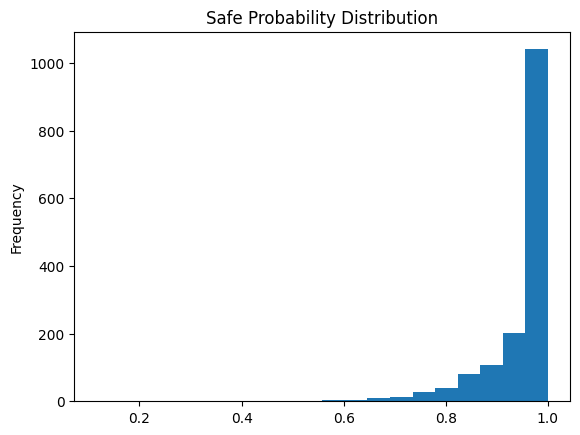

In [196]:
final_probs['safe_probability'].plot(kind='hist', bins=20, title='Safe Probability Distribution')